In [79]:
# %load_ext autoreload
# %autoreload 2

# Set Trial Name

In [80]:
TRIAL_NAME = "2_bin_stratified"

import datetime
import pytz
NOW = datetime.datetime.now(pytz.timezone('Asia/Tokyo')).strftime('%Y%m%d%H%M%S')

# Load yaml

In [81]:
import yaml
CONFIG_DIR = '../config'
with open(f'{CONFIG_DIR}/run000.yml') as file:
    cfg = yaml.safe_load(file)

import sys
sys.path.append(cfg['SRC_DIR'])
cfg['run_name'] = TRIAL_NAME

# fix seed

In [82]:
from util import seed_everything
seed_everything(seed=33, use_torch=False)

# Make Output Folder

In [83]:
import os
OUTPUT_DIR = f'../../output/{NOW}_{TRIAL_NAME}'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Load Model

In [84]:
import pandas as pd
sub = pd.read_csv('../../data/atmacup10__sample_submission.csv')
color = pd.read_csv('../../data/color.csv')
historical_person = pd.read_csv('../../data/historical_person.csv')
maker = pd.read_csv('../../data/maker.csv')
material = pd.read_csv('../../data/material.csv')
object_collection = pd.read_csv('../../data/object_collection.csv')
palette = pd.read_csv('../../data/palette.csv')
principal_maker_occupation = pd.read_csv('../../data/principal_maker_occupation.csv')
principal_maker = pd.read_csv('../../data/principal_maker.csv')
production_place = pd.read_csv('../../data/production_place.csv')
technique = pd.read_csv('../../data/technique.csv')
test = pd.read_csv('../../data/test.csv')
train = pd.read_csv('../../data/train.csv')

# train

In [85]:
train.head(2)

,object_id,art_series_id,title,description,long_title,principal_maker,principal_or_first_maker,sub_title,copyright_holder,more_title,acquisition_method,acquisition_date,acquisition_credit_line,dating_presenting_date,dating_sorting_date,dating_period,dating_year_early,dating_year_late,likes
0,0011d6be41612ec9eae3,93c092ba70beab248f31,The Avenue of Birches,NaN,"The Avenue of Birches, Jan Hackaert, 1660 - 1685",Jan Hackaert,Jan Hackaert,h 66.5cm × w 53.7cm × t 2.5cm × d 4.7cm,NaN,The Avenue of Birches,purchase,1808-01-01T00:00:00,NaN,1660 - 1685,1660.0,17,1660.0,1685.0,48
1,0012765f7a97ccc3e9e9,95c14fb11c54281ad7e0,Struik in bloei,NaN,"Struik in bloei, Richard Tepe (attributed to),...",Richard Tepe,Richard Tepe,h 165mm × w 223mm,erven Richard Tepe,Struik in bloei,purchase,2000-01-01T00:00:00,NaN,c. 1900 - c. 1930,1900.0,19,1900.0,1930.0,2


In [88]:
test.head(2)

,object_id,art_series_id,title,description,long_title,principal_maker,principal_or_first_maker,sub_title,copyright_holder,more_title,acquisition_method,acquisition_date,acquisition_credit_line,dating_presenting_date,dating_sorting_date,dating_period,dating_year_early,dating_year_late
0,000405d9a5e3f49fc49d,a2aabd3cc8859f4260ad,Twee personen voor de Duizendjarige den te Wol...,NaN,Twee personen voor de Duizendjarige den te Wol...,Bernardus Bruining,Bernardus Bruining,h 167mm × w 108mm,NaN,Twee personen voor de Duizendjarige den te Wol...,transfer,1994-01-01T00:00:00,NaN,1850 - 1900,1850.0,19,1850.0,1900.0
1,001020bd00b149970f78,5d6a286cc3ab64c2c043,"Portrait of Philipp Ernst, Count of Hohenlohe ...","Portret van Philip Ernst (1585-1629), graaf va...","Portrait of Philipp Ernst, Count of Hohenlohe ...",Jan Antonisz van Ravesteyn,Jan Antonisz van Ravesteyn,h 29.7cm × w 24.1cm,NaN,"Portrait of Philipp Ernst, Count of Hohenlohe ...",nationalization 1795,1798-09-01T00:00:00,NaN,c. 1609 - c. 1633,1609.0,17,1609.0,1633.0


In [91]:
# import sweetviz as sv

# #最後の引数には目的変数を指定
# my_report = sv.compare([train, "Train"], [test, "Test"], "likes")
 
# #直接ブラウザに表示
# my_report.show_html("Report.html")

# reduce mem usage

In [92]:
# from util import reduce_mem_usage
# train_feat_df = reduce_mem_usage(train_feat_df)
# test_feat_df = reduce_mem_usage(test_feat_df)

# del not common value between train and test

In [93]:
train.columns

Index(['object_id', 'art_series_id', 'title', 'description', 'long_title',
       'principal_maker', 'principal_or_first_maker', 'sub_title',
       'copyright_holder', 'more_title', 'acquisition_method',
       'acquisition_date', 'acquisition_credit_line', 'dating_presenting_date',
       'dating_sorting_date', 'dating_period', 'dating_year_early',
       'dating_year_late', 'likes', 'fold'],
      dtype='object')

In [94]:
del_non_overlapping_list = [
    'object_id',
    'art_series_id',
    'title',
    'description',
    'long_title',
    'principal_maker',
    'principal_or_first_maker',
    'sub_title',
    'copyright_holder',
    'more_title',
    'acquisition_method',
    'acquisition_date',
    'acquisition_credit_line',
    'dating_presenting_date',
    'dating_sorting_date',
    'dating_period',
    'dating_year_early',
    'dating_year_late'
]

from util import replace_non_overlap_val_to_missing
train, test = replace_non_overlap_val_to_missing(train,test,columns=del_non_overlapping_list)

# Lable Encoding

In [95]:
cat_col = train.select_dtypes('O').columns.tolist()

In [96]:
from fe import label_encode
train, test = label_encode(train, test, cat_col)

In [97]:
train.dtypes

object_id                     int64
art_series_id                 int64
title                         int64
description                   int64
long_title                    int64
principal_maker               int64
principal_or_first_maker      int64
sub_title                     int64
copyright_holder              int64
more_title                    int64
acquisition_method            int64
acquisition_date              int64
acquisition_credit_line       int64
dating_presenting_date        int64
dating_sorting_date         float64
dating_period                 int64
dating_year_early           float64
dating_year_late            float64
likes                         int64
fold                          int64
dtype: object

# add fold

In [98]:
# from fold import add_fold_kf
# train = add_fold_kf(train,fold_num=5)

from fold import add_fold_bin_skf
train = add_fold_bin_skf(train, train[cfg['target']], fold_num=5, bins=[0,1,10,100,1000, 27392])

# Make Model

In [99]:
use_col = train.columns.tolist()
use_col.remove('fold')
use_col.remove(cfg['target'])

In [100]:
use_col

['object_id',
 'art_series_id',
 'title',
 'description',
 'long_title',
 'principal_maker',
 'principal_or_first_maker',
 'sub_title',
 'copyright_holder',
 'more_title',
 'acquisition_method',
 'acquisition_date',
 'acquisition_credit_line',
 'dating_presenting_date',
 'dating_sorting_date',
 'dating_period',
 'dating_year_early',
 'dating_year_late']

In [101]:
# 学習直前でwandbにログイン、こうしないと頻繁にnotebookが落ちる
from use_wandb import use_wandb
use_wandb(params=cfg['params'], PROJECT_NAME=cfg['competition_name'], TRIAL_NAME=TRIAL_NAME)
# e99ecbcc2d9a775a09280213a06af1cf174d0fe0

wandb: Currently logged in as: sinchir0 (use `wandb login --relogin` to force relogin)


/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/__init__.py:42: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  warnings.warn("Starting from version 2.2.1, the library file in distribution wheels for macOS "
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shinichiro.saito/opt/anac

--------------FOLDS : 0 --------------
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 575.828	valid_1's rmse: 673.845
[200]	training's rmse: 548.232	valid_1's rmse: 674.847
Early stopping, best iteration is:
[145]	training's rmse: 562.343	valid_1's rmse: 673.485
Fold 0 rmsle: 2.6124
--------------FOLDS : 1 --------------


/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1246: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['acquisition_credit_line', 'acquisition_date', 'acquisition_method', 'art_series_id', 'copyright_holder', 'dating_presenting_date', 'description', 'long_title', 'more_title', 'object_id', 'principal_maker', 'principal_or_first_maker', 'sub_title', 'title']
  warnings.warn('categorical_feature in Datase

Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 585.846	valid_1's rmse: 637.707
[200]	training's rmse: 556.832	valid_1's rmse: 637.737
Early stopping, best iteration is:
[177]	training's rmse: 562.586	valid_1's rmse: 637.38
Fold 1 rmsle: 2.5214
--------------FOLDS : 2 --------------


/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1246: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['acquisition_credit_line', 'acquisition_date', 'acquisition_method', 'art_series_id', 'copyright_holder', 'dating_presenting_date', 'description', 'long_title', 'more_title', 'object_id', 'principal_maker', 'principal_or_first_maker', 'sub_title', 'title']
  warnings.warn('categorical_feature in Datase

Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 604.494	valid_1's rmse: 545.095
[200]	training's rmse: 575.561	valid_1's rmse: 546.723
Early stopping, best iteration is:
[100]	training's rmse: 604.494	valid_1's rmse: 545.095
Fold 2 rmsle: 2.8058
--------------FOLDS : 3 --------------
Training until validation scores don't improve for 100 rounds


/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1246: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['acquisition_credit_line', 'acquisition_date', 'acquisition_method', 'art_series_id', 'copyright_holder', 'dating_presenting_date', 'description', 'long_title', 'more_title', 'object_id', 'principal_maker', 'principal_or_first_maker', 'sub_title', 'title']
  warnings.warn('categorical_feature in Datase

[100]	training's rmse: 624.058	valid_1's rmse: 453.674
[200]	training's rmse: 595.874	valid_1's rmse: 454.065
[300]	training's rmse: 573.562	valid_1's rmse: 451.861
[400]	training's rmse: 554.829	valid_1's rmse: 452.239
Early stopping, best iteration is:
[382]	training's rmse: 557.64	valid_1's rmse: 451.291
Fold 3 rmsle: 2.0568
--------------FOLDS : 4 --------------
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 548.139	valid_1's rmse: 765.257


/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1246: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['acquisition_credit_line', 'acquisition_date', 'acquisition_method', 'art_series_id', 'copyright_holder', 'dating_presenting_date', 'description', 'long_title', 'more_title', 'object_id', 'principal_maker', 'principal_or_first_maker', 'sub_title', 'title']
  warnings.warn('categorical_feature in Datase

[200]	training's rmse: 522.696	valid_1's rmse: 758.759
[300]	training's rmse: 502.883	valid_1's rmse: 752.777
[400]	training's rmse: 486.886	valid_1's rmse: 749.837
[500]	training's rmse: 474.377	valid_1's rmse: 748.155
Early stopping, best iteration is:
[472]	training's rmse: 477.531	valid_1's rmse: 747.975
Fold 4 rmsle: 2.0272
ALL likes rmsle:  2.4247


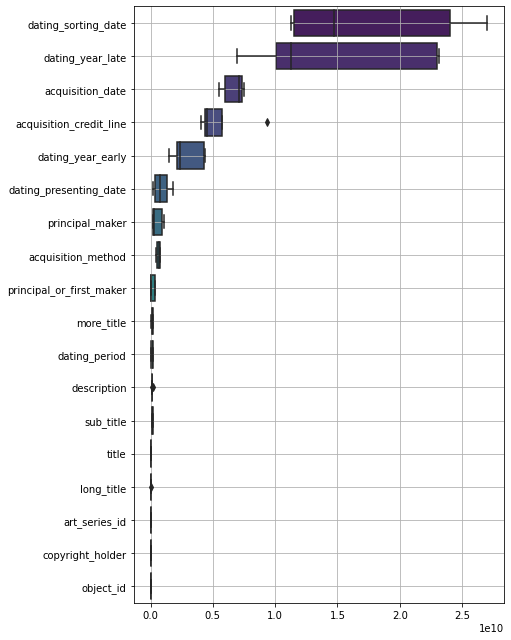

In [102]:
from fe import target_encoding
from lgbm import LGBM

lgbm = LGBM(train=train,
  test=test,
  target='likes',
  use_col=use_col,
  cat_col=cat_col,
  cfg=cfg,
  OUTPUT_DIR=OUTPUT_DIR,
  DO_FIT=True,
  DO_SEED_AVE=False,
  DEBUG=False)

feature_importance_df, order = lgbm.feature_importance()

In [103]:
from make_data import make_oof
oof_df = make_oof(OUTPUT_DIR=OUTPUT_DIR, TARGET=cfg['target'])

In [104]:
# from score import calc_macro_auc
# score = calc_macro_auc(train_target_df=train_target_df, oof_df=oof_df, order_list=TARGET_IDS)

In [105]:
sample_sub = pd.read_csv('../../data/atmacup10__sample_submission.csv')

In [106]:
from make_data import make_sub
sub_df = make_sub(sample_sub=sample_sub, TARGET_NAME=cfg['target'], TRIAL_NAME=TRIAL_NAME, OUTPUT_DIR=OUTPUT_DIR, cv_score=lgbm.score)

QUick Sub
sh sub.sh output/20210307112251_2_bin_stratified/pred/pred_likes_2.4247.csv


In [107]:
sub.head()

,likes
0,68.500677
1,9.184876
2,22.090073
3,68.801811
4,58.470058


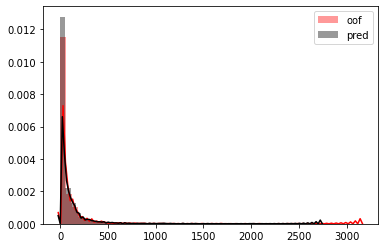

In [108]:
from make_fig import make_dist_oof_pred
make_dist_oof_pred(oof_df=oof_df,sub_df=sub_df,OUTPUT_DIR=OUTPUT_DIR)